In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/17marchm1/pixelwarunet_model1.pth
/kaggle/input/train1/Train/low/641.png
/kaggle/input/train1/Train/low/173.png
/kaggle/input/train1/Train/low/491.png
/kaggle/input/train1/Train/low/718.png
/kaggle/input/train1/Train/low/709.png
/kaggle/input/train1/Train/low/248.png
/kaggle/input/train1/Train/low/94.png
/kaggle/input/train1/Train/low/480.png
/kaggle/input/train1/Train/low/236.png
/kaggle/input/train1/Train/low/771.png
/kaggle/input/train1/Train/low/675.png
/kaggle/input/train1/Train/low/48.png
/kaggle/input/train1/Train/low/677.png
/kaggle/input/train1/Train/low/761.png
/kaggle/input/train1/Train/low/655.png
/kaggle/input/train1/Train/low/227.png
/kaggle/input/train1/Train/low/762.png
/kaggle/input/train1/Train/low/726.png
/kaggle/input/train1/Train/low/238.png
/kaggle/input/train1/Train/low/61.png
/kaggle/input/train1/Train/low/222.png
/kaggle/input/train1/Train/low/330.png
/kaggle/input/train1/Train/low/511.png
/kaggle/input/train1/Train/low/579.png
/kaggle/input/train

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

def calculate_psnr(output, target, max_val=1.0):
    mse = F.mse_loss(output, target)
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr

class LowLightDataset(Dataset):
    def __init__(self, low_dir, high_dir, transform=None):
        self.low_dir = low_dir
        self.high_dir = high_dir
        self.low_images = os.listdir(low_dir)
        self.high_images = os.listdir(high_dir)
        self.transform = transform

        if len(self.low_images) != len(self.high_images):
            print("Warning: The number of images in low_dir and high_dir are not the same.")
            self.low_images = self.low_images[:min(len(self.low_images), len(self.high_images))]
            self.high_images = self.high_images[:min(len(self.low_images), len(self.high_images))]

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.low_images[idx])
        high_img_path = os.path.join(self.high_dir, self.high_images[idx])

        low_image = Image.open(low_img_path).convert("RGB")
        high_image = Image.open(high_img_path).convert("RGB")

        if self.transform:
            low_image = self.transform(low_image)
            high_image = self.transform(high_image)

        return low_image, high_image

transform = transforms.Compose([
    transforms.ToTensor()
])

train_low_dir = '/kaggle/input/train1/Train/low'
train_high_dir = '/kaggle/input/train1/Train/high'
val_low_dir = 
val_high_dir = 

train_dataset = LowLightDataset(train_low_dir, train_high_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part wala code of U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part wala code of U-Net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Down part wala code
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # Up part wala code
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:], mode='bilinear')

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
    
model = UNet(in_channels=3, out_channels=3)


class MLPBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(MLPBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(hidden_channels, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        
        x1 = self.conv1(x)
        
        x1 = self.gelu(x1)
        x1 = self.conv2(x1)
        
        x1 = self.sigmoid(x1)
        x = x + x1
        
        return x

class PixelWarriorNetwork(nn.Module):
    def __init__(self, in_channels=3, num_blocks=6, num_out_channels=3, features=[64, 128, 256, 512]):
        super(PixelWarriorNetwork, self).__init__()
        self.downsampler = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1)
        self.mlp_blocks = nn.ModuleList([MLPBlock(in_channels, in_channels * 2) for _ in range(num_blocks)])
        self.upsampler = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)
        self.unet = UNet(in_channels, num_out_channels, features)

    def forward(self, x):
        x = self.downsampler(x)

        for block in self.mlp_blocks:
            x = block(x)

        x = self.upsampler(x)
        x = self.unet(x)

        return x

model = PixelWarriorNetwork(in_channels=3, num_blocks=6, num_out_channels=3, features=[64, 128, 256, 512])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
import torch

model = PixelWarriorNetwork(in_channels=3)

model_path = "/kaggle/input/17marchm1/pixelwarunet_model1.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

print("Model loaded successfully")

Model loaded successfully


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import math
import tqdm as tqdm

# Assuming you have already defined the UNet and LowLightDataset classes

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the number of epochs
num_epochs = 10

# Training loop
for epoch in tqdm.tqdm(range(num_epochs)):
    running_loss = 0.0
    running_psnr = 0.0

    for low_images, high_images in train_loader:
        low_images = low_images.to(device)
        high_images = high_images.to(device)

        optimizer.zero_grad()

        outputs = model(low_images)
        loss = criterion(outputs, high_images)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute PSNR
        psnr = 10 * torch.log10(1 / criterion(outputs, high_images))
        running_psnr += psnr

    epoch_loss = running_loss / len(train_loader)
    epoch_psnr = running_psnr / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, PSNR: {epoch_psnr:.2f} dB")


    model.train()

# Save the trained model
torch.save(model.state_dict(), "pixelwar+unet_model1.pth")

 10%|█         | 1/10 [02:12<19:52, 132.55s/it]

Epoch [1/10], Loss: 0.0051, PSNR: 23.53 dB


 20%|██        | 2/10 [04:24<17:37, 132.13s/it]

Epoch [2/10], Loss: 0.0054, PSNR: 23.35 dB


 30%|███       | 3/10 [06:36<15:23, 131.96s/it]

Epoch [3/10], Loss: 0.0051, PSNR: 23.52 dB


 40%|████      | 4/10 [08:47<13:10, 131.80s/it]

Epoch [4/10], Loss: 0.0049, PSNR: 23.67 dB


 50%|█████     | 5/10 [10:59<10:58, 131.78s/it]

Epoch [5/10], Loss: 0.0050, PSNR: 23.71 dB


 60%|██████    | 6/10 [13:10<08:46, 131.67s/it]

Epoch [6/10], Loss: 0.0054, PSNR: 23.33 dB


 70%|███████   | 7/10 [15:22<06:34, 131.57s/it]

Epoch [7/10], Loss: 0.0052, PSNR: 23.40 dB


 80%|████████  | 8/10 [17:33<04:23, 131.55s/it]

Epoch [8/10], Loss: 0.0049, PSNR: 23.67 dB


 90%|█████████ | 9/10 [19:45<02:11, 131.56s/it]

Epoch [9/10], Loss: 0.0052, PSNR: 23.46 dB


100%|██████████| 10/10 [21:57<00:00, 131.72s/it]

Epoch [10/10], Loss: 0.0049, PSNR: 23.61 dB


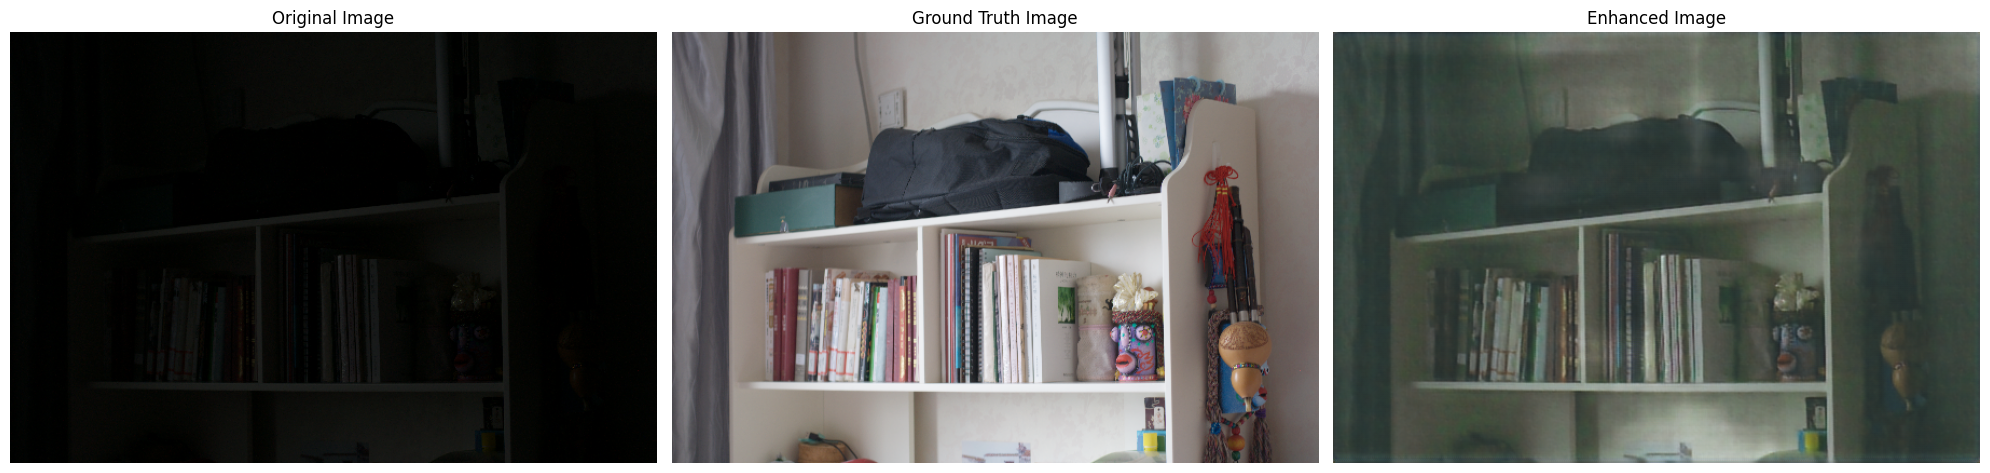

In [21]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

model.eval()
transform = transforms.Compose([
    transforms.Resize((400, 600)),
    transforms.ToTensor()
])

input_image_path = '/kaggle/input/train1/Train/low/12.png'
ground_truth_path = '/kaggle/input/train1/Train/high/12.png'

input_image = Image.open(input_image_path).convert('RGB')
ground_truth_image = Image.open(ground_truth_path).convert('RGB')

# Display the original input image, ground truth image, and enhanced image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
ax1.imshow(input_image)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(ground_truth_image)
ax2.set_title('Ground Truth Image')
ax2.axis('off')

input_tensor = transform(input_image).unsqueeze(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_tensor = input_tensor.to(device)

with torch.no_grad():
    enhanced_tensor = model(input_tensor)
    enhanced_tensor = enhanced_tensor.cpu()

enhanced_image = transforms.ToPILImage()(enhanced_tensor.squeeze())
ax3.imshow(enhanced_image)
ax3.set_title('Enhanced Image')
ax3.axis('off')

plt.tight_layout()
plt.show()

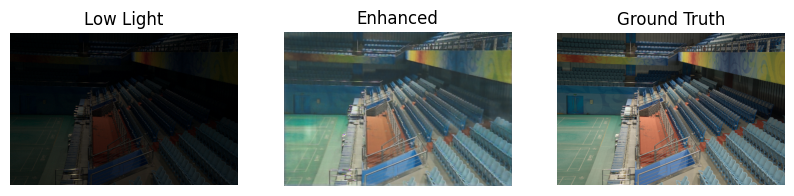

PSNR: 22.36 dB


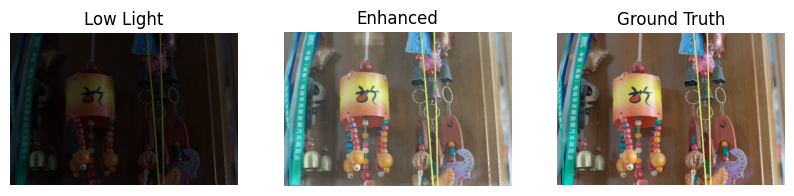

PSNR: 22.94 dB


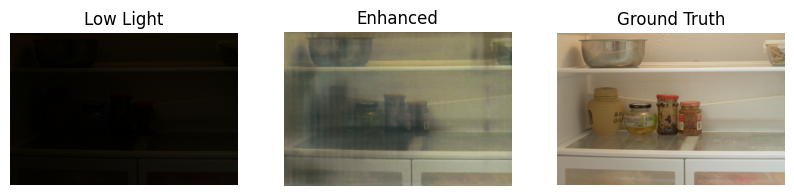

PSNR: 16.15 dB


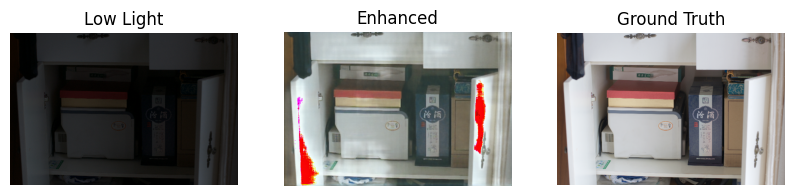

PSNR: 22.41 dB


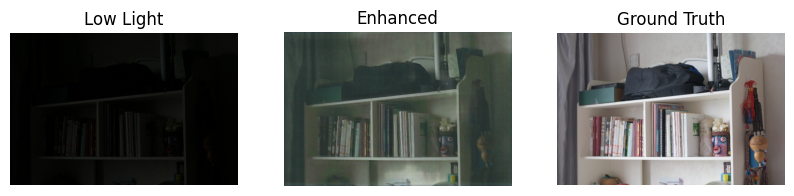

PSNR: 12.58 dB
Average PSNR: 19.29 dB


In [25]:
import torch

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

import random
import cv2
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

# Rest of your code...

model.eval()
transform = transforms.Compose([
    transforms.Resize((400, 592)),
    transforms.ToTensor() 
])
model.eval()

low_dir = '/kaggle/input/train1/Train/low'
high_dir = '/kaggle/input/train1/Train/high'

low_images = os.listdir(low_dir)

random_images = random.sample(low_images,5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

psnr_values = []

for image_name in random_images:
    input_image_path = os.path.join(low_dir, image_name)
    high_image_path = os.path.join(high_dir, image_name)
    input_image = Image.open(input_image_path).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(device)
    with torch.no_grad():
        enhanced_tensor = model(input_tensor).cpu()

    enhanced_image = transforms.ToPILImage()(enhanced_tensor.squeeze())

    original_image = cv2.imread(high_image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))  
    axs[0].imshow(input_image)
    axs[0].set_title('Low Light')
    axs[0].axis('off')
    
    axs[1].imshow(enhanced_image)
    axs[1].set_title('Enhanced')
    axs[1].axis('off')
    
    axs[2].imshow(original_image_rgb)
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')
    
    plt.show()
    
    original_tensor = transform(Image.fromarray(original_image_rgb)).unsqueeze(0)
    psnr_value = psnr(original_tensor, enhanced_tensor)
    psnr_values.append(psnr_value)
    print(f'PSNR: {psnr_value:.2f} dB')
average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.2f} dB')